<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap
import jax_cosmo as jc
from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, make_ode_fn
from montecosmo.bricks import lpt as mylpt, Planck18
from montecosmo.models import get_pk_fn

feynmangpu04.cluster.local
gpu


2024-07-31 14:14:17.809493: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


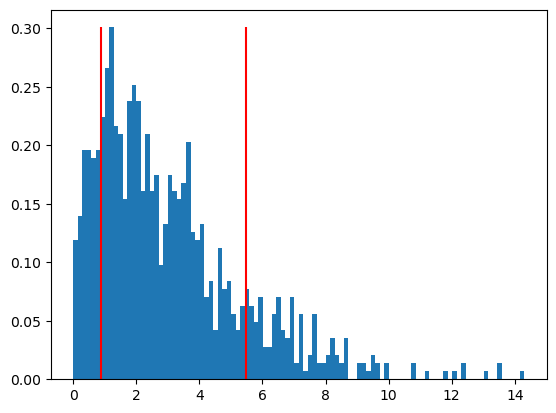

In [2]:
aa = jr.normal(jr.key(0), (10000,))
from scipy.stats import ncx2
aa = ncx2(3,0).rvs(1000)
from montecosmo.metrics import qbi, hdi
h, b, _ = plt.hist(aa, 100, density=True)
a, b = qbi(aa, 0.7)
plt.vlines(a, 0, h.max(), color='r')
plt.vlines(b, 0, h.max(), color='r')

In [13]:
mesh_length = 32
mesh_shape = mesh_length*np.array([1,1,1])
box_shape  = np.array([640.,640.,640.])

multipoles = [0,2,4]
pk_fn = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles)
zeros_mesh = jnp.zeros(mesh_shape)

def likelihood_model(rng_key, loc_mesh, mesh_shape, box_shape, galaxy_density, obs_name):
    """
    A likelihood for cosmological model.

    Return an observed mesh sampled from a location mesh with observational variance.
    """
    sigma2 = 1.

    if obs_name == 'mesh':
        # Normal noise
        sigma2 /= (galaxy_density * (box_shape / mesh_shape).prod())
        # obs_mesh = sample('obs', dist.Normal(loc_mesh, jnp.sqrt(sigma2)))
        obs_mesh = loc_mesh + jnp.sqrt(sigma2) * jr.normal(rng_key, mesh_shape)
        return obs_mesh
    
    elif obs_name == 'pk':
        # Anisotropic power spectrum covariance, cf. [Grieb+2016](http://arxiv.org/abs/1509.04293)
        multipoles = jnp.array([0,2,4])
        sli_multip = slice(1,1+jnp.shape(multipoles)[0])
        loc_pk, Nk = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles, kcount=True)(loc_mesh)
        # sigma2 *= ((2*multipoles[:,None]+1)/galaxy_density)**2 / Nk
        sigma2 *= 2*(2*multipoles[:,None]+1) * (1 / galaxy_density**2 + 2*loc_pk[1]/galaxy_density) / Nk
        lambd = galaxy_density * Nk * loc_pk[1]

        loc_pk = loc_pk.at[1].add(1/galaxy_density) # add shot noise to the mean power spectrum
        # obs_pk = loc_pk.at[sli_multip].set(sample('obs', dist.Normal(loc_pk[sli_multip], jnp.sqrt(sigma2))))
        obs_pk = loc_pk.at[sli_multip].set(loc_pk[sli_multip] + jnp.sqrt(sigma2) * jr.normal(rng_key, loc_pk[sli_multip].shape))
        print(loc_pk[sli_multip].shape, jnp.sqrt(sigma2).shape, loc_pk[sli_multip].shape)
        return obs_pk, sigma2, lambd, Nk

def run_simulation(rng_key, cosmology, obs_name):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    # rng_key, init_key = jr.split(rng_key)
    init_key = jr.key(0)
    mesh = linear_field(mesh_shape, box_shape, pk_fn, seed=init_key)

    # # Create particles
    # particles = jnp.indices(mesh_shape).reshape(3,-1).T

    # # Initial displacement
    # cosmology._workspace = {}  # FIX ME: this a temporary fix
    # dx, p, f = mylpt(cosmology, mesh, particles, a=.5)

    obs = likelihood_model(rng_key, mesh, mesh_shape, box_shape, galaxy_density=1e-3, obs_name=obs_name)
    return obs

In [14]:
cosmology = Planck18()
print(f"Fiducial {cosmology}")
a_lpt, a_obs = 0.1, 0.5
rng_key = jr.key(1)
n = 50_000

res = vmap(partial(run_simulation, cosmology=cosmology, obs_name='mesh'))(jr.split(rng_key, n))
pk_mesh = jit(vmap(pk_fn))(res)
pk_spect, sigma2, lambd, Nk = vmap(partial(run_simulation, cosmology=cosmology, obs_name='pk'))(jr.split(rng_key, n))

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/sit

(3, 16) (3, 16) (3, 16)


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [2]:
import math
def wigner3j_square(ellout, ellin, prefactor=True):
    r"""
    Return the coefficients corresponding to the product of two Legendre polynomials, corresponding to :math:`C_{\ell \ell^{\prime} L}`
    of e.g. eq. 2.2 of https://arxiv.org/pdf/2106.06324.pdf, with :math:`\ell` corresponding to ``ellout`` and :math:`\ell^{\prime}` to ``ellin``.

    Parameters
    ----------
    ellout : int
        Output order.

    ellin : int
        Input order.

    prefactor : bool, default=True
        Whether to include prefactor :math:`(2 \ell + 1)/(2 L + 1)` for window convolution.

    Returns
    -------
    ells : list
        List of mulipole orders :math:`L`.

    coeffs : list
        List of corresponding window coefficients.
    """
    qvals, coeffs = [], []

    def G(p):
        """
        Return the function G(p), as defined in Wilson et al 2015.
        See also: WA Al-Salam 1953
        Taken from https://github.com/nickhand/pyRSD.

        Parameters
        ----------
        p : int
            Multipole order.

        Returns
        -------
        numer, denom: int
            The numerator and denominator.
        """
        toret = 1
        for p in range(1, p + 1): toret *= (2 * p - 1)
        return toret, math.factorial(p)

    for p in range(min(ellin, ellout) + 1):

        numer, denom = [], []

        # numerator of product of G(x)
        for r in [G(ellout - p), G(p), G(ellin - p)]:
            numer.append(r[0])
            denom.append(r[1])

        # divide by this
        a, b = G(ellin + ellout - p)
        numer.append(b)
        denom.append(a)

        numer.append(2 * (ellin + ellout) - 4 * p + 1)
        denom.append(2 * (ellin + ellout) - 2 * p + 1)

        q = ellin + ellout - 2 * p
        if prefactor:
            numer.append(2 * ellout + 1)
            denom.append(2 * q + 1)

        coeffs.append(np.prod(numer, dtype='f8') * 1. / np.prod(denom, dtype='f8'))
        qvals.append(q)

    return qvals[::-1], coeffs[::-1]


wigner3j_square(2,4, False)

([2, 4, 6], [0.2857142857142857, 0.2597402597402597, 0.45454545454545453])

In [ ]:
from scipy.special import legendre
xs = np.linspace(-1,1)
ell1, ell2 = 3, 1
plt.plot(xs, legendre(ell1)(xs)*legendre(ell2)(xs))

ells, coeffs = wigner3j_square(ell1,ell2, False)
L1L2 = lambda x: sum([coeff * legendre(ell)(x) for coeff, ell in zip(coeffs, ells)])
plt.plot(xs, L1L2(xs))


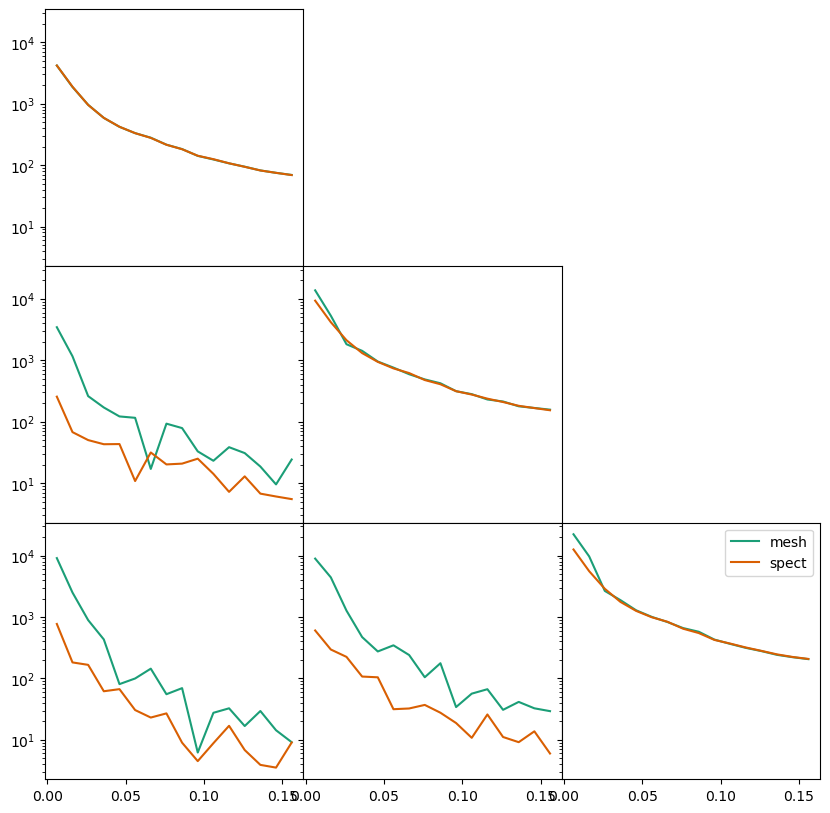

In [15]:
cmap = plt.get_cmap('Dark2')
covs_mesh = vmap(jnp.cov)(pk_mesh[:,1:].T)
covs_spect = vmap(jnp.cov)(pk_spect[:,1:].T)
covs = [covs_mesh, covs_spect]
labels = ["mesh", "spect"]
L = len(multipoles)

fig, axarr = plt.subplots(L,L, figsize=(10,10), sharex=True,sharey=True)
plt.locator_params(nbins=5)
for i in range(L):
    for j in range(L):
        if j <= i:
            for i_exp in range(len(covs)):
                axarr[i,j].semilogy(pk_mesh[0,0], jnp.abs(covs[i_exp][:,i,j])**.5, color=cmap(i_exp), label=labels[i_exp])
                # axarr[i,j].semilogy(pk_mesh[0,0], covs[i_exp][:,i,j], color=cmap(i_exp), label=labels[i_exp])
        else:
            axarr[i,j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0) 
# plt.tight_layout()
plt.legend()

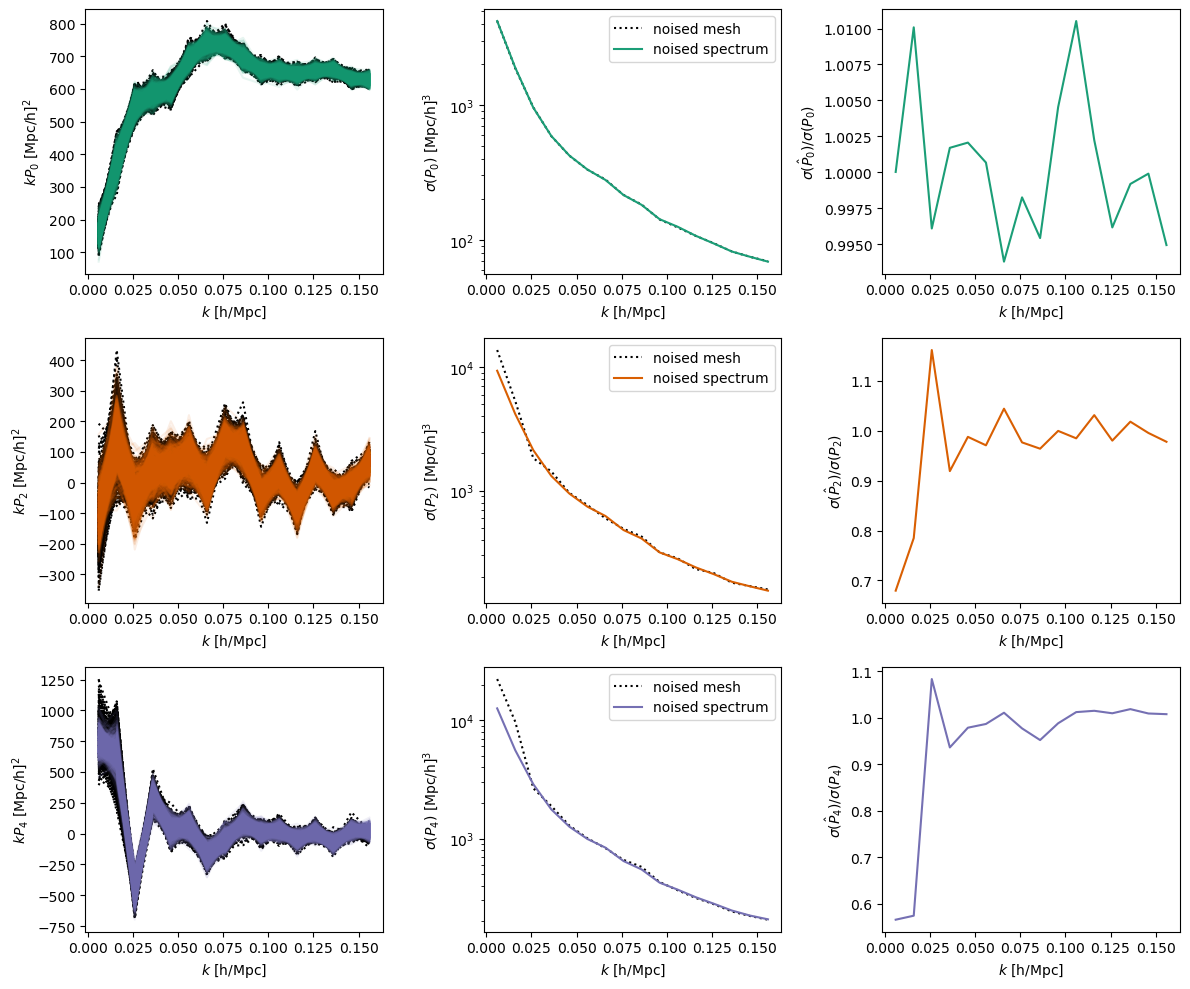

In [26]:
cmap = plt.get_cmap('Dark2')
# relerr = lambda x, true: jnp.abs(x-true)/jnp.abs(true)
relerr = lambda x, true: x/true
plt.figure(figsize=(12,10))
n_col = 3
n_toplot = int(1e3)
for i_ell, ell in enumerate(multipoles):
    plt.subplot(3,n_col,n_col*i_ell+1)
    plt.plot(pk_mesh[:n_toplot,0].T, (pk_mesh[:n_toplot,0]*pk_mesh[:n_toplot,i_ell+1]).T, ':k')
    plt.plot(pk_spect[:n_toplot,0].T, (pk_spect[:n_toplot,0]*pk_spect[:n_toplot,i_ell+1]).T, color=cmap(i_ell), alpha=.1)
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{ell}$ [Mpc/h]$^2$")
    # plt.plot(pk_spect[:,0].T, relerr(pk_spect[:,0]*pk_spect[:,i_ell+1], pk_mesh[:,0]*pk_mesh[:,i_ell+1]).T, color=cmap(i_ell))
    plt.subplot(3,n_col,n_col*i_ell+2)
    std_mesh = pk_mesh[:,i_ell+1].std(0)
    std_spect = pk_spect[:,i_ell+1].std(0)
    plt.semilogy(pk_mesh[0,0], std_mesh, ':k', label="noised mesh")
    plt.semilogy(pk_spect[0,0], std_spect, color=cmap(i_ell), label="noised spectrum")
    # plt.semilogy(pk_mesh[0,0], pk_mesh[0,0]*pk_mesh[:,i_ell+1].std(0), ':k', label="noised mesh")
    # plt.semilogy(pk_spect[0,0], pk_mesh[0,0]*pk_spect[:,i_ell+1].std(0), color=cmap(i_ell), label="noised spectrum")
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$\\sigma (P_{ell})$ [Mpc/h]$^3$")
    plt.legend()
    plt.subplot(3,n_col,n_col*i_ell+3)
    plt.plot(pk_spect[0,0], relerr(std_spect, std_mesh), color=cmap(i_ell))
    # plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$|\\sigma (\\hat P_{ell})/\\sigma (P_{ell}) -1|$")
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$\\sigma (\\hat P_{ell})/\\sigma (P_{ell})$")
plt.tight_layout()

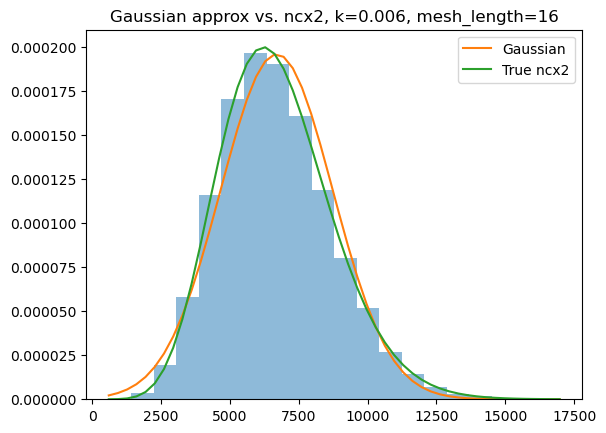

In [12]:
idk_tp = 0
idell_tp = 0
pk_tp = pk_mesh[:,idell_tp+1,idk_tp]
from scipy.stats import norm, ncx2
plt.hist(pk_tp, bins=20, density=True, alpha=0.5)

pdf_fn = lambda x: norm.pdf(x, loc=pk_tp.mean(), scale=sigma2[0,idell_tp,idk_tp]**.5)
pdf_true_fn = lambda x: ncx2.pdf(x, df=Nk[0,idk_tp], nc=lambd[0,idk_tp], scale=1/(1e-3 * Nk[0,idk_tp]))
ps = jnp.linspace(pk_tp.min(), pk_tp.max())
plt.plot(ps, pdf_fn(ps), label="Gaussian")
plt.plot(ps, pdf_true_fn(ps), label="True ncx2")
plt.title(f"Gaussian approx vs. ncx2, k={pk_mesh[0,0,idk_tp]:.3f}, mesh_length={mesh_length:d}")
plt.legend()
plt.show()

For small $k$ and small resolution, chi2 has not converged to Gaussian yet. For higher $k$ or bigger mesh, the approximation holds nicely.